### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv('../lab-eda-univariate/amz_uk_price_prediction_dataset.csv')

In [3]:
cbt = pd.crosstab(df["category"],df['isBestSeller'])
cbt['Proportion'] = (cbt[True] / cbt[False]) # proportion of bestsellers for each category (unnormalized)
cbt['Proportion'] = cbt['Proportion'] / cbt['Proportion'].sum()
cbt

isBestSeller,False,True,Proportion
category,,,
3D Printers,247,1,0.002177
3D Printing & Scanning,4065,2,0.000265
Abrasive & Finishing Products,245,5,0.010972
Action Cameras,1696,1,0.000317
Adapters,251,3,0.006426
...,...,...,...
Wind Instruments,243,7,0.015487
Window Treatments,234,5,0.011488
Women,17559,213,0.006522


2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

In [4]:
from scipy.stats import chi2_contingency

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(cbt.iloc[:, :2])
chi2_statistic, chi2_p_value

(36540.20270061387, 0.0)

In [5]:
from scipy.stats.contingency import association
association(cbt.iloc[:, :2], method = "cramer")

0.1222829439760564

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

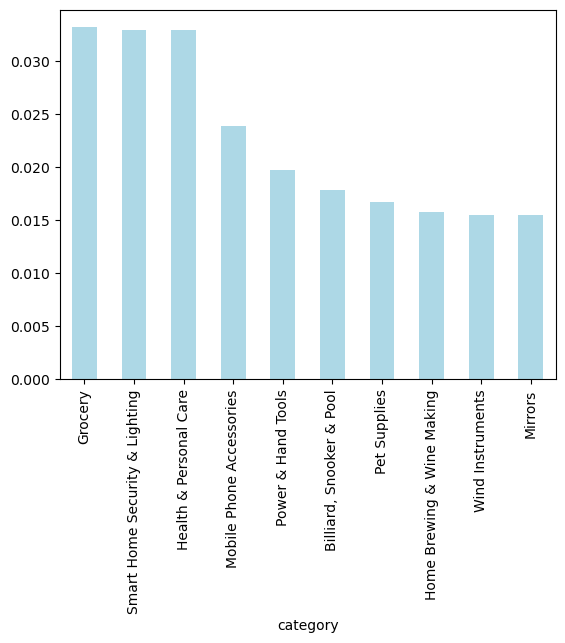

In [7]:
top_categories = cbt["Proportion"].sort_values(ascending=False).head(10)
top_categories.plot(kind = "bar", color = 'lightblue');

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

In [17]:
# modify outlier values
def tukeys_test_outliers_modified(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return (data >= lower_bound) & (data <= upper_bound)

In [20]:
clean_prices = tukeys_test_outliers_modified(df['price'])
print(len(df))
df = df[clean_prices]
print(len(df))

2443651
1958911


1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

In [25]:
top_20_categories = df['category'].value_counts().sort_values(ascending = False).head(20)
top_20_categories

category
Sports & Outdoors                         639487
Beauty                                     19051
Bath & Body                                18907
Manicure & Pedicure Products               18812
Make-up                                    18657
Hair Care                                  18463
Skin Care                                  18437
Handmade Clothing, Shoes & Accessories     18349
Birthday Gifts                             17839
Handmade Gifts                             17552
Handmade Home Décor                        17327
Handmade Kitchen & Dining                  17270
Handmade Home & Kitchen Products           16999
Women                                      16870
Handmade Artwork                           16842
Luggage and travel gear                    16768
Handmade Jewellery                         15779
Fragrances                                 15372
Men                                        15228
Baby                                       14659
Name: count

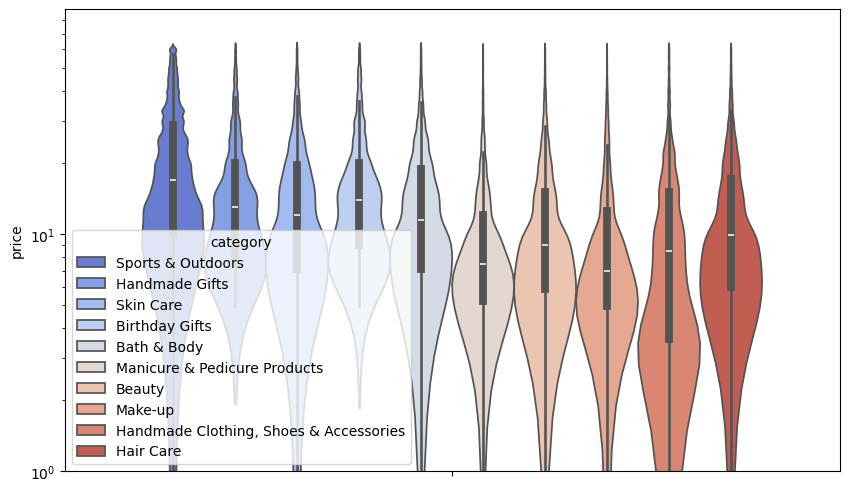

In [42]:
plt.figure(figsize = (10,6))
sns.violinplot(data = df[df['category'].isin(top_20_categories.index) & (df['price'] >= 0.1)], hue = 'category', y = 'price', palette="coolwarm")
plt.yscale('log')
plt.ylim(1e0);

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

In [31]:
top_10_categories = df['category'].value_counts().sort_values(ascending = False).head(10)

category
Bath & Body                               14.224890
Beauty                                    11.915752
Birthday Gifts                            16.730221
Hair Care                                 12.890633
Handmade Clothing, Shoes & Accessories    11.384923
Handmade Gifts                            16.006575
Make-up                                   10.403883
Manicure & Pedicure Products               9.913918
Skin Care                                 14.855345
Sports & Outdoors                         20.702439
Name: price, dtype: float64

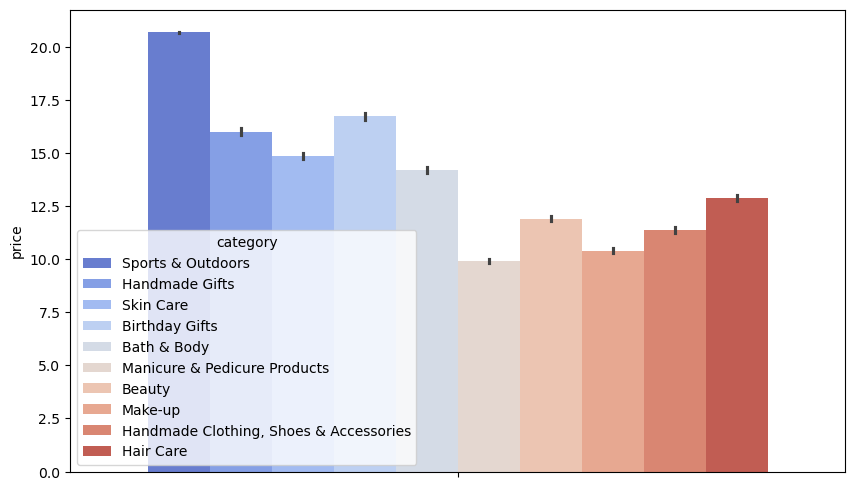

In [39]:
plt.figure(figsize = (10,6))
sns.barplot(data = df[df['category'].isin(top_10_categories.index)], hue = 'category', y = 'price', palette="coolwarm");

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

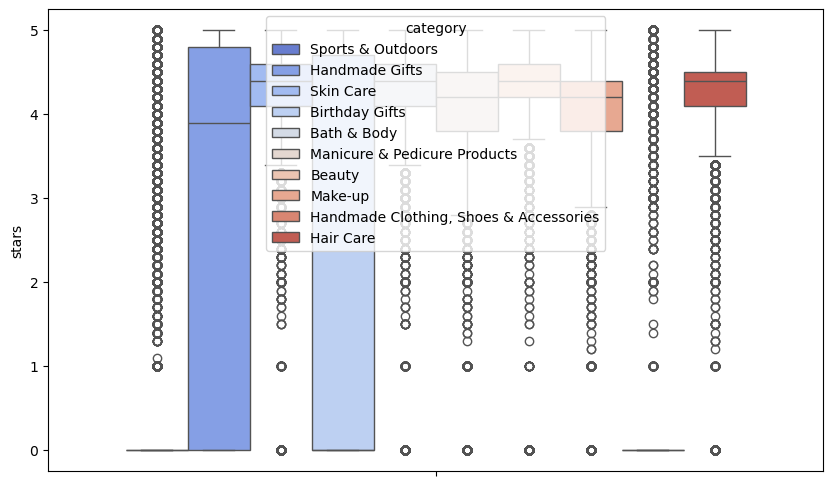

In [43]:
plt.figure(figsize = (10,6))
sns.boxplot(data = df[df['category'].isin(top_10_categories.index)], hue = 'category', y = 'stars', palette="coolwarm");

### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?

In [45]:
# Pearson Correlation
pearson_correlation = df['price'].corr(df['stars'])
pearson_correlation

-0.008505653615885598

In [48]:
# Spearman Correlation
spearman_correlation = df['price'].corr(df['stars'], method='spearman')
spearman_correlation

-0.014390810680393395

Since the pearson correlation coefficient is very close to zero, it suggests that there is no linear relationship between product pricing and their rating. The negative spearman correlation is also close to zero, indicating no monotonic relationship between these two variables.

2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 

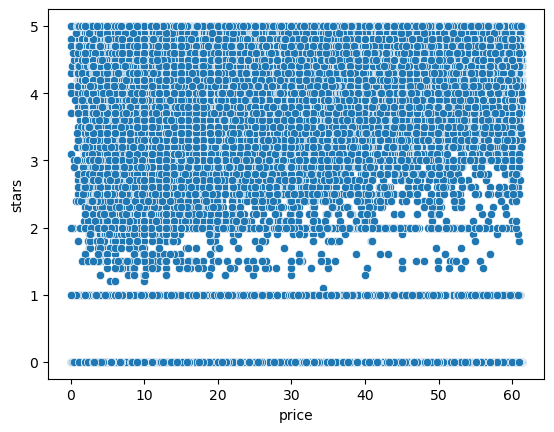

In [50]:
sns.scatterplot(data=df, x='price', y='stars');

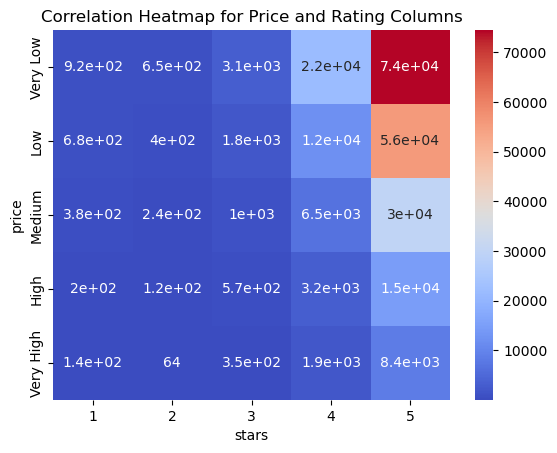

In [58]:
price_bins = pd.cut(df['price'], bins=np.linspace(df['price'].min(), df['price'].max(), 6), labels=["Very Low", "Low", "Medium", "High", "Very High"])
stars_bins = pd.cut(df['stars'], bins=np.linspace(df['stars'].min(), df['stars'].max(), 6), labels=["1", "2", "3", "4", "5"])

correlation_matrix = pd.crosstab(price_bins, stars_bins)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap for Price and Rating Columns")
plt.show()

The heatmap shows a distinct pattern for the 5-star products - there are way more products with very low prices than with very high ones. In contrast, there is no relationship between the price of low-rated products.

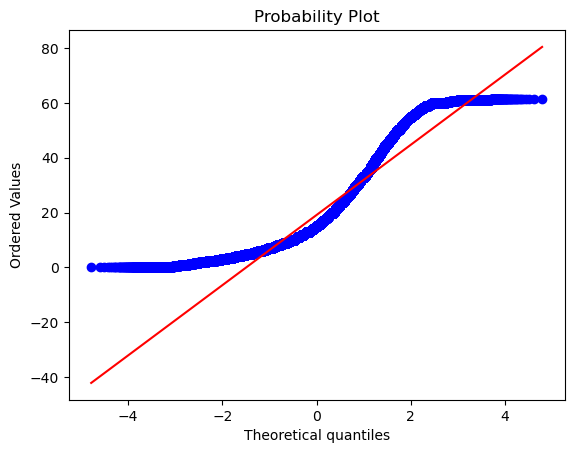

In [62]:
from scipy import stats
stats.probplot(df['price'], plot=plt);

The price does not follow a normal distribution.